<a href="https://colab.research.google.com/github/paolapersico1/YelpSentimentAnalysis/blob/master/YelpBusinessClusteringAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**YELP BUSINESS CLUSTERING**

#**Introduction**

Clustering is an unsupervised learning problem; it deals with finding a structure in a collection of unlabeled data. A loose definition of clustering could be “the process of organizing objects into groups whose members are similar in some way” [1]. A cluster is therefore a collection of objects which are “similar” between them and are “dissimilar” to the objects belonging to other clusters [2].

Our goal is to apply clustering to find an hidden correlation among several businesses into the Yelp Open Dataset. For testing purpose, the algorithm takes as input a location and applies the clustering to the business of that particular location. 

The algorithm we implemented consists of the following phases:
1. Business categories pre-processing
2. Business categories feature extraction
3. Business filtering based on location
4. K-means business clustering


**Data storage setting and libraries import**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
MODEL_FOLDER = "/content/drive/My Drive/Models/"
FOLDER = "/content/drive/My Drive/Datasets/business/"
#MODEL_FOLDER = "/content/drive/My Drive/Models/business/"

import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec
from joblib import dump, load
from tabulate import tabulate
import pickle

Mounted at /content/drive


# **Data pre-processing**

Data pre-processing is an important step because of the "Garbage In Garbage Out" principle: quality data is necessary for quality models. 

**Dataset Import**

In order to avoid a RAM overflow, the json dataset is read in chunks of 1 million rows; useless columns and rows with missing values are dropped; and only the first chunk is converted to csv.

In [ ]:
#cutted out all colums except 4 ones: business_id, name,city and category
def load_businesses_yelp_data(output_filename, limit = False, chunksize = 1000000):
  business = pd.read_json(FOLDER + "yelp_dataset_business.json", lines=True,
                        dtype={'business_id':str,'name':str,'address':str,
                               'city':str,'state':str,'postal_code':str,
                               'latitude':float,'longitude':float,'stars':float,
                               'review_count':int,'is_open':int,'attributes':object,
                               'categories':str,'hours':object},
                        chunksize=chunksize)
  
  # There are multiple chunks to be read
  chunk_list = []
  for chunk_business in business:
    # Drop columns that aren't needed
    chunk_business = chunk_business.drop(['address', 'state', 'postal_code', 'latitude', 'longitude', 'is_open','stars','review_count','attributes','hours'], axis=1)
    # Drop rows with missing values
    chunk_business = chunk_business.dropna()
    # Add chunk
    chunk_list.append(chunk_business)
    if limit and len(chunk_list) == limit:
      break
  # Concatenate the trimmed chunks to one dataframe
  df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
  # convert to csv
  df.to_csv(output_filename, index=False)

# load the csv
yelp_business_csv = FOLDER + "yelp_business.csv"
if os.path.isfile(yelp_business_csv) and os.access(yelp_business_csv, os.R_OK):
    print("File exists and is readable")
else:
  print("Either the file is missing or not readable, we create a new one")
  load_businesses_yelp_data(yelp_business_csv, limit = 1)

File exists and is readable


In [ ]:
#let's create a dataframe
dset = pd.read_csv(yelp_business_csv)
print("dset rows: "+str(len(dset)) )

dset rows: 209393


**Tokenization and stemming**

Each category list is converted into a list of lowercase tokens and accent marks are removed. Every token is then stemmed to its root, e.g. "consultant" and "consulting" are both stemmed to "consult".

In [ ]:
# Tokenize each category list
dset['tokenized_cat'] = [simple_preprocess(line, deacc=True) for line in dset['categories']] 
# Stem each word
porter_stemmer = PorterStemmer()
dset['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in dset['tokenized_cat']]

#**Feature Extraction**

Feature extraction is necessary because we need to transform each list of strings into a representation suitable for the learning algorithm. To be exact, each distinct word in the vocabulary has to correspond to a numerical feature. We use the Word2Vec model already generated for this purpose.


In [ ]:
word2vec_model_file = MODEL_FOLDER + 'word2vec_model'
# load the model 
w2v_model = Word2Vec.load(word2vec_model_file)

**Word-embeddings datasets generation**

Each list of categories is converted from a list of stemmed tokens to a vector of floating point numbers, which is obtained computing the mean of the word embeddings of each stemmed tokens. If non-valid values are encountered, the mean vector is a vector of all 0s, which doesn't affect the classification.

In [ ]:
missing_keys = 0
found_keys = 0

# function to get the vector representing a word
def get_word2vec(word):
    global missing_keys
    global found_keys
    try:
        result = w2v_model[word]
        found_keys = found_keys + 1
    except:
        result = 0
        missing_keys = missing_keys + 1
    finally:
        return result

In [ ]:
def get_word2vec_dataset(dataset, filename):
  word2vec_filename = FOLDER + filename
  if os.path.isfile(word2vec_filename) and os.access(word2vec_filename, os.R_OK):
      print("File exists and is readable")
  else:
    print("Either the file is missing or not readable, we create a new one")
    # Store the vectors for data in a file
    with open(word2vec_filename, 'w+') as word2vec_file:
        for index, row in dataset.iterrows():
            #average over all the word2vec embeddings of the categories
            model_vector = (np.mean([get_word2vec(token) for token in row['stemmed_tokens']], axis=0)).tolist()
            if index == 0:
                header = ",".join(str(ele) for ele in range(300))
                word2vec_file.write(header)
                word2vec_file.write("\n")
            # Check if the line exists else it is vector of zeros
            if type(model_vector) is list:  
                line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
            else:
                line1 = ",".join([str(0) for i in range(300)])
            word2vec_file.write(line1)
            word2vec_file.write('\n')

    print("Missing keys: ", missing_keys)
    print("Found keys: ", found_keys)
  # Load from the filename
  df = pd.read_csv(word2vec_filename)
  print("The " + filename + " dataset is ready to be used")
  return df

#retrieve the word2vec train dataset
mSet = get_word2vec_dataset(dset, 'categories_business.csv')

File exists and is readable
The categories_business.csv dataset is ready to be used


#**K-Means clustering**

K-means clustering is one of the simplest clustering algorithm. It only needs one input: the number of clusters. It starts by defining k centroids (one for each cluster) and then assigning the data points to the cluster with the nearest centroid at each step and computing the new centroids, until no changes occur anymore.

**Elbow evaluation for optimal number of clusters**

The elbow method runs k-means clustering on the dataset for a range of values for k (in our case from 10 to 250 with a 20 points step). Then for each value of k it computes an average score for all clusters. By default, the distortion score is computed: the sum of square distances from each point to its assigned center. 

Other metrics can also be used such as the silhouette score, the mean silhouette coefficient for all samples or the calinski_harabasz score, which computes the ratio of dispersion between and within clusters.

When these overall metrics for each model are plotted, it is possible to visually determine the best value for k. If the line chart looks like an arm, then the “elbow” (the point of inflection on the curve) is the best value of k. The “arm” can be either up or down, but if there is a strong inflection point, it is a good indication that the underlying model fits best at that point [3].

now is executing with k = 10
now is executing with k = 30
now is executing with k = 50
now is executing with k = 70
now is executing with k = 90
now is executing with k = 110
now is executing with k = 130
now is executing with k = 150
now is executing with k = 170
now is executing with k = 190
now is executing with k = 210
now is executing with k = 230


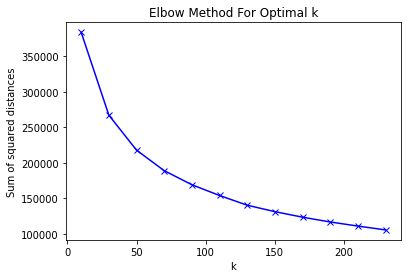

In [ ]:
Sum_of_squared_distances = []
K = range(10,250,20)

for k in K:
    print("now is executing with k = " + str(k))
    km = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=1)
    km = km.fit(mSet)
    Sum_of_squared_distances.append(km.inertia_)


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()    

We selected 90 as optimal number of cluster.
We apply k-means to the categories and we add a new column with the cluster index.

In [ ]:
n_categories = 90
model = KMeans(n_clusters=n_categories, init='k-means++', max_iter=500, n_init=1)
y = model.fit_predict(mSet)
dset['cat_label'] = y;

**Businesses categories distribution visualization**

In [ ]:
import pickle 
toFile = dset.loc[:,['cat_label','business_id']]
toFile.to_pickle(FOLDER+"BusinessesCluster")

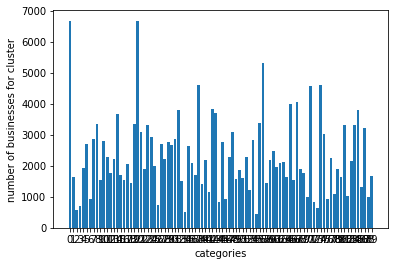

In [ ]:
res = dset.loc[:,['cat_label','name','categories']]
res = res.sort_values("cat_label")

mMap = {}

for i in range(n_categories):
    mMap[str(i)]=[]

for y in res.values:
    index = str(y[0])
    elem = [y[h] for h in range(1,len(y))]
    mMap[index].append(elem)

mDictionary = {}
for i in range(n_categories):
    mDictionary[str(i)]=[]


for i in range(len(mMap)):
    index = str(i);
    toPrint = mMap[index];
    mDictionary[index] = len(toPrint);

#Function to bar plot a dictionary
def plot_dict(dict, metric_name):
  label = dict.keys()
  rng = range(len(label))
  plt.xticks(rng, label)
  p = plt.bar(rng, dict.values(), 0.8)
  plt.ylabel(metric_name)
  plt.xlabel('categories')
  plt.rcParams["figure.figsize"] = (90,30)
  plt.show()


plot_dict(mDictionary, 'number of businesses for cluster')

Below a snipped code that can be used to verify the elements inside a distribution

In [ ]:
n = input("which category number do you want to show? ")
index = str(n)
toPrint = mMap[index]

print ('the category ', index ,'contains',len(toPrint),"businesses");
print ('the first 10 are ... ');
stop = 0 ;

results = [];
results = [str(i) for i in range(10)];    
for x in toPrint:
    #names and descriptions
    results[stop] = [ str(x[0]) , str(x[1]) ];
    stop = stop+1;
    if stop == 10:
        break;

print(tabulate(results, headers=["Names", "Descriptions"]))

which category number do you want to show? 4
the category  4 contains 1922 businesses
the first 10 are ... 
Names                             Descriptions
--------------------------------  ----------------------------------------------------------------------------------------------------------------------
Poffie Girls Bridals & Formals    Event Planning & Services, Wedding Planning, Accessories, Bridal, Formal Wear, Women's Clothing, Fashion, Shopping
The Next Generation               Thrift Stores, Baby Gear & Furniture, Children's Clothing, Women's Clothing, Fashion, Shopping, Toy Stores
Children's Orchard Huntersville   Baby Gear & Furniture, Shopping, Fashion, Toy Stores, Children's Clothing
Stein Mart                        Fashion, Shopping, Men's Clothing, Women's Clothing, Home Decor, Children's Clothing, Department Stores, Home & Garden
Bare Essentials-Fantasy Fashions  Shopping, Lingerie, Women's Clothing, Costumes, Accessories, Fashion, Arts & Crafts
Elegansia Fashion Shop 

#**Filtering businesses by location**



In [ ]:
#cities pre-processing
import string
test_cities = ["LAS VEGAS", " Las Vegas ", "274 Las Vegas", "Las-vegas", "las vegas"]

def preprocess_city(city):
    #to string
    city = str(city)
    #remove numbers
    city = ''.join([i for i in city if not i.isdigit()])
    #remove hyphens
    city = city.replace('-', ' ')
    #remove commas
    city = city.replace(',', ' ')
    #to lowercase
    city = city.lower()
    #remove leading and trailing spaces
    city = city.strip()
    #capitalize first letters
    city = city.title()

    return city

test_cities = map(preprocess_city, test_cities)
for city in test_cities:
    print(city)

Las Vegas
Las Vegas
Las Vegas
Las Vegas
Las Vegas


In [ ]:
dset['city'] = dset['city'].map(preprocess_city)

In [ ]:
#show to the user the list of available cities and make them select one 
temp = dset['city'].unique()
temp = sorted(temp)

print(str( len(temp) )  + ' cities available:' );
print('\n')

for city in temp:
    print(city)
while True:
  city = preprocess_city(input('\nChoose a city among city list: '));
  if city in temp:
    print ("City accepted √")
    break
  else:
    print("City not found. Check the name and try again, please.")

1117 cities available:


Agincourt
Ahwahtukee
Ahwatukee
Ahwatukee Foothills Village
Airdrie
Ajax
Akron
Alberta
Alburg
Alburgh
Allegheny
Allentown
Allison Park
Ambridge
Amherst
Ange Gardien
Anjou
Ansnorveldt
Anthem
Antioch
Apache Junction
Apache Trail
Arizona
Arnold
Arrowhead
Arsenal
Ashburn
Aspinwall
Auburn
Auburn Twp
Aurora
Austinburg
Avalon
Avon
Avon Lake
Avondale
Az
Baie D'Urfe
Baie D'Urfé
Bainbridge
Bainbridge Township
Bakerstown
Baldwin
Ballantyne
Balzac
Banksville
Bapchule
Barberton
Bath
Bay Village
Beachwood
Beaconsfield
Beauharnois
Bedford
Bedford Heights
Bedford Hts
Bedford Hts.
Beeton
Belle Vernon
Belleville
Bellevue
Bellvue
Belmont
Beloeil
Beltline
Belœil
Ben Avon
Bentleyville
Berea
Berry
Bethel Park
Black Earth
Black Rock City
Blainville
Blakeney
Blawnox
Bloomfield
Blue Diamond
Blue Mounds
Bois Des Filion
Boisbriand
Bolton
Bond Head
Boston
Boston Heights
Boucherville
Boulder City
Braddock
Bradford
Bradford West Gwillimbury
Bradford Woods
Bradfordwoods
Brampton
Brampton Fka 

In [ ]:
businessesCitySet = dset[dset["city"] == city]
print( str(len(businessesCitySet))+" businesses found in "+str(city) ) 

31678 businesses found in Las Vegas


#**Business clustering**

Once the city has been selected, we take all the businesses of that city and we cluster them by category.


In [ ]:
res = businessesCitySet.loc[:,['cat_label','name','categories']]
res = res.sort_values("cat_label")

mMap = {}

for i in range(n_categories):
    mMap[str(i)]=[]

for y in res.values:
    index = str(y[0])
    #print('index = '+index);
    elem = [y[h] for h in range(1,len(y))]
    #print("elem =  "+str(elem))
    mMap[index].append(elem)

for i in range(len(mMap)):
    index = str(i);
    toPrint = mMap[index];
    print('\n\ncluster '+str(index)+', number of businesses : '+str(len( toPrint) )+"\n" );
    stop = 0;
    results = [];
    results = [i for i in range(5)];
    for x in toPrint:
        results[stop] = [str(x[0]), str(x[1]) ];
        stop = stop+1;
        if stop==5:
            break;
    
    if len(toPrint)>1:
        print(tabulate(results, headers=["Names", "Descriptions"]))
    else:
        print("Names \t\t\t\t Descriptions")
        print("--------------------- \t\t ---------------------")
        print(results[0][0]," \t\t ",results[0][1] );



cluster 0, number of businesses : 591

Names                      Descriptions
-------------------------  -------------------------------------------------------------------------------
Excellence In Denistry     Health & Medical, Dentists, General Dentistry
Nguyen-Su Suzie Ddsitd     General Dentistry, Dentists, Health & Medical
Decatur Children's Dental  Pediatric Dentists, Health & Medical, Dentists, Oral Surgeons
Peccole Family Dental      Dentists, General Dentistry, Cosmetic Dentists, Health & Medical, Orthodontists
Painted Desert Dental      Health & Medical, Dentists, Cosmetic Dentists, General Dentistry


cluster 1, number of businesses : 333

Names                            Descriptions
-------------------------------  ----------------------------------------------------------------------------------------------------------------------------------
Olive Garden Italian Restaurant  Bars, Salad, Nightlife, Wine Bars, Italian, Restaurants, Soup
Nora's Italian Cuisine          

#**References**
[1] Unsupervised Learning and Data Clustering. Sanatan Mishra. 2017. Retrieved from https://towardsdatascience.com/unsupervised-learning-and-data-clustering-eeecb78b422a

[2] Clustering. Shimon Ullman, Tomaso Poggio, Danny Harari, Daneil Zysman, Darren Seibert. 2014. Retrieved from http://www.mit.edu/~9.54/fall14/slides/Class13.pdf

[3] Elbow Method. The scikit-yb developers. 2019. Retrieved from https://www.scikit-yb.org/en/latest/api/cluster/elbow.html